# Importation des dépendances

Dans cette premiere partie, on importe toutes les dépendances nécessaire au bon déroulement du jupyter notebook.

In [16]:
import cv2
import glob
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

# Définition des fonctions utilisées dans le notebook

- data_input va chacune image du dataset et la convertir en un format compréhensible par l'algorithme
- setup_data va retourner une liste contenant chacune des images ainsi que leur label (Normal ou pneumonie)
- load_data va retourner deux arrays (X = Images et Y = label)
- calculate_weight permet d'équilibrer les données en calculant le nombre d'images normales et d'images de pneumonie et en faisant un ratio


In [17]:
def data_input(dataset):
    for image in dataset:
        im = cv2.imread(str(image))
        im = cv2.resize(im, (224,224))
        if im.shape[2] == 1:
            im = np.dstack([im, im, im])
        x_image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        x_image = x_image.astype(np.float32)/255.
        return x_image

In [18]:
def setup_data(PATH, dir, type, label):
    #Liste du chemins de toutes les images
    images_path = Path(PATH + dir + type).glob('*.jpeg')

    #Liste contenant le chemin de l'image et son label
    type_data = [(img, label) for img in images_path]

    return type_data


In [19]:
def load_data(dir):
    # Définition du chemin vers le dossier contenant les images
    PATH = "chest_Xray"

    #Classement des images de test
    normal_data = setup_data(PATH, dir, '/NORMAL', 0)
    pneumonia_data = setup_data(PATH, dir, '/PNEUMONIA', 1)
    img_data = normal_data + pneumonia_data

    #Création du panda dataframe
    img_data = pd.DataFrame(img_data, columns=['image', 'label']).sample(frac=1., random_state=100).reset_index(drop=True)

    #Importation des images et des labels
    x_images = np.array([data_input(img_data.iloc[i][:]) for i in range(len(img_data))])
    y_labels = np.array([img_data.iloc[i][1] for i in range(len(img_data))])
    
    x_images = x_images.reshape(x_images.shape[0],x_images.shape[1]*x_images.shape[2]*x_images.shape[3])
    
    return x_images, y_labels

In [20]:
def calculate_weight(dir):
    PATH = "chest_Xray"
    normal_data = setup_data(PATH, dir, '/NORMAL', 0)
    pneumonia_data = setup_data(PATH, dir, '/PNEUMONIA', 1)

    COUNT_NORMAL = len(normal_data)
    COUNT_PNEUMONIA = len(pneumonia_data)
    TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA

    weight_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
    weight_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

    class_weight = {0: weight_0, 1: weight_1}
    return class_weight

In [21]:
def metrics_calc(model, dataset_x, dataset_y):
    ypred = model.predict(dataset_x)
    err = mean_squared_error(ypred, dataset_y)
    accuracy = metrics.accuracy_score(dataset_y, ypred)

    model_probs = model.predict_proba(dataset_x)
    loss = log_loss(ypred, model_probs)

    return err, accuracy, loss

def metrics_plot(curves, xlabel, ylabel):
    plt.plot ( [c[0] for c in curves], [c[1] for c in curves], label="train")
    plt.plot ( [c[0] for c in curves], [c[2] for c in curves], label="test")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Création du model

On calcule d'abord le poids de nos datasets, puis on va ensuite charger nos différents datasets.
On va ensuite entrainer notre model avec les données de train.
On peut voir grâce au graphique que le nombre de n_estimators va jouer sur la précision du model.

In [22]:
class_weight_train = calculate_weight('/train')
print("Weight of train : ", class_weight_train)
class_weight_test = calculate_weight('/test')
print("Weight of test : ", class_weight_test)
class_weight_normal = calculate_weight('/val')
print("Weight of value : ", class_weight_normal)

Weight of train :  {0: 1.9448173005219984, 1: 0.6730322580645162}
Weight of test :  {0: 1.3333333333333335, 1: 0.8}
Weight of value :  {0: 1.0, 1: 1.0}


In [23]:
x_train, y_train = load_data('/train')
x_test, y_test = load_data('/test')
x_val, y_val = load_data('/val')

In [24]:
model = RandomForestClassifier(n_estimators=1000, class_weight=class_weight_train)
model.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 1.9448173005219984,
                                     1: 0.6730322580645162},
                       n_estimators=1000)

Train : n_estimators 1 erreur 0.04869631901840491 accuracy 0.9513036809815951 loss 9.992007221626413e-16
Test : n_estimators 1 erreur 0.2692307692307692 accuracy 0.7307692307692307 loss 9.992007221626413e-16
Train : n_estimators 2 erreur 0.040452453987730064 accuracy 0.95954754601227 loss 0.05102924028662266
Test : n_estimators 2 erreur 0.21153846153846154 accuracy 0.7884615384615384 loss 0.14329484982729718
Train : n_estimators 3 erreur 0.014762269938650307 accuracy 0.9852377300613497 loss 0.04749600863767122
Test : n_estimators 3 erreur 0.23557692307692307 accuracy 0.7644230769230769 loss 0.12085979183993437
Train : n_estimators 4 erreur 0.01111963190184049 accuracy 0.9888803680981595 loss 0.054850430000068215
Test : n_estimators 4 erreur 0.21153846153846154 accuracy 0.7884615384615384 loss 0.1472453165248714
Train : n_estimators 5 erreur 0.008052147239263804 accuracy 0.9919478527607362 loss 0.049671897001066015
Test : n_estimators 5 erreur 0.2724358974358974 accuracy 0.7275641025641

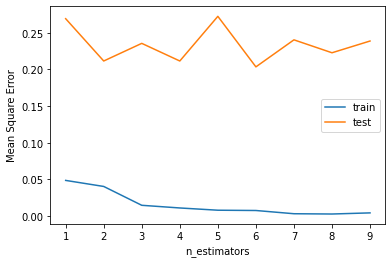

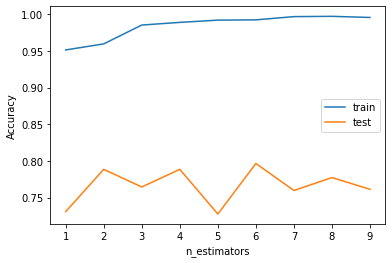

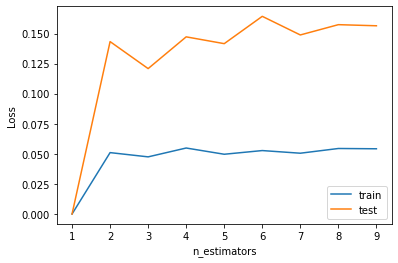

In [25]:
from sklearn import metrics
from sklearn.metrics import log_loss
curves = []
curves2 = []
curves3 = []
for n_estimators in range(1,10,1) :
    forest = RandomForestClassifier(n_estimators=n_estimators, class_weight=class_weight_train)
    forest = forest.fit(x_train, y_train)

    err_train, accuracy_train, loss_train = metrics_calc(forest, x_train, y_train)
    err_test, accuracy_test, loss_test = metrics_calc(forest, x_test, y_test)

    print("Train : n_estimators",n_estimators, "erreur",err_train, "accuracy", accuracy_train, "loss", loss_train)
    curves.append((n_estimators, err_train, err_test, forest))
    curves2.append((n_estimators, accuracy_train, accuracy_test, forest))
    curves3.append((n_estimators, loss_train, loss_test, forest))

    print("Test : n_estimators",n_estimators, "erreur",err_test, "accuracy", accuracy_test, "loss", loss_test)

metrics_plot(curves, 'n_estimators', 'Mean Square Error')
metrics_plot(curves2, 'n_estimators', 'Accuracy')
metrics_plot(curves3, 'n_estimators', 'Loss')

In [26]:
ypred = model.predict(x_test)

# Calcul des différentes métriques du modèle

On va donc calculer différentes métriques :

- L'accuracy du modèle qui correspond à la précision de celui-ci dans la prédiction d'images sur lequel il n'est pas entrainé
- Une matrice de confusion qui permet de voir simplement le nombre d'erreurs et de réussite qu'il y a eu sur le dataset
- Le nombre d'erreurs moyen sur le dataset (0.24)
- Le pourcentage de perte du modèle (0.17830502637701842)
- Le calcul de l'AUC (Plage comprise entre 0 et 1, si toutes les prédictions sont correctes, son AUC est de 1,0)
  Il faut donc avoir un AUC le plus proche possible de 1, 0,92 est donc un AUC correct


In [27]:
from sklearn import metrics

print(metrics.classification_report(ypred, y_test))
print(metrics.accuracy_score(y_test, ypred))

              precision    recall  f1-score   support

           0       0.35      0.98      0.52        85
           1       0.99      0.72      0.84       539

    accuracy                           0.75       624
   macro avg       0.67      0.85      0.68       624
weighted avg       0.91      0.75      0.79       624

0.7548076923076923


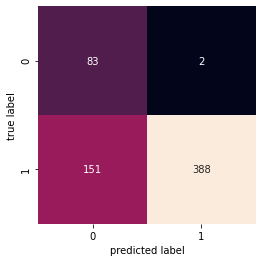

In [28]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('true label');

In [29]:
# Calcul du nombre d'erreurs moyen avec les valeurs prédites
erreurs = abs(ypred - y_test)
print('Mean Absolute Error:', round(np.mean(erreurs), 2))

Mean Absolute Error: 0.25


In [30]:
from sklearn.metrics import log_loss

clf_probs = model.predict_proba(x_test)
score = log_loss(ypred, clf_probs)
print(score)

0.17862334317055334


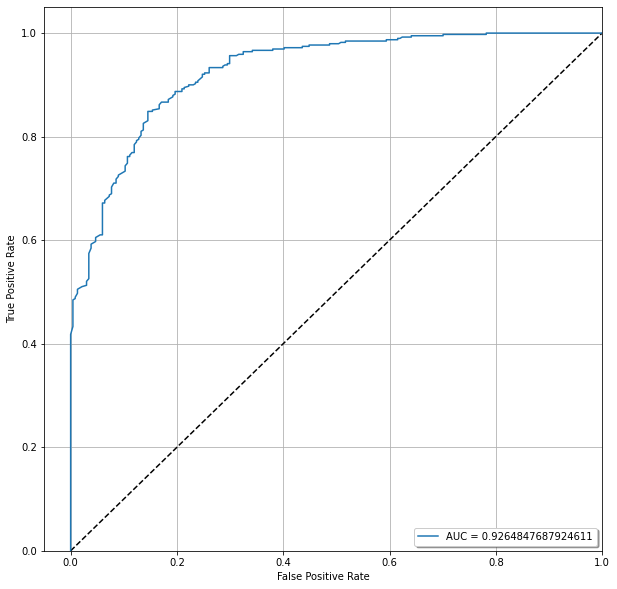

In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# overall accuracy
acc = model.score(x_test,y_test)

# get roc/auc info
Y_score = model.predict_proba(x_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))
plt.legend(loc="lower right", shadow=True, fancybox =True)
plt.show()